In [ ]:
!nvidia-smi

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries


In [2]:
import os
import glob
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import load_svmlight_file
import pandas as pd
import gc
from matplotlib import pyplot as plt
from seaborn import heatmap
from sklearn.tree import DecisionTreeClassifier

## Load and preprocess imdb training data for logistic regression, change path if needed

In [3]:

with open("drive/MyDrive/aclImdb/imdb.vocab", 'r', encoding="utf-8") as file:
    words_list = [line.strip() for line in file]
X, y = load_svmlight_file("drive/MyDrive/aclImdb/train/labeledBow.feat")


# Convert the sparse matrix to a dense matrix
X_dense = X.todense()
del X
gc.collect()
# Convert the matrix to a pandas df, where columns are word indices, rows are reviews and entries are word counts in the review
df_1 = pd.DataFrame(X_dense)
del X_dense
gc.collect()
# A word occurs in a review if its count is non-zero
occurrence_frequency = (df_1 != 0).sum() / len(df_1)
words_to_remove = occurrence_frequency[(occurrence_frequency < 0.01) | (occurrence_frequency > 0.5)].index
df_1_filtered = df_1.drop(columns=words_to_remove)
df_1 = df_1_filtered
filtered_indices_list = df_1.columns.to_list()
filtered_words_list = [words_list[i] for i in filtered_indices_list]
filtered_words_dict = dict(zip(filtered_words_list,filtered_indices_list))


print("Training data loaded and filtered.")

Training data loaded and filtered.


## Using simple linear regression, find the most positive/negative words to reduce vocabulary size

In [4]:
def find_coefficient(df, word_index, ratings):
    # simple linear regression to find coefficient
    X = df.loc[:, word_index].values
    y = np.array(ratings)
    mean_x = np.mean(X)
    mean_y = np.mean(y)
    num = np.sum((X - mean_x) * (y - mean_y))
    denom = np.sum((X - mean_x) ** 2)

    return num / denom
def assign_coefficients(df, ratings):
    tuple_list = []
    for i in np.array(df.columns):
        tuple_list.append(tuple((i,find_coefficient(df,i,ratings))))

    return sorted(tuple_list, key=lambda x: x[1])
coefficient_tuples = assign_coefficients(df_1,y)
coefficients_dict = {}
for ind, coef in coefficient_tuples:
    coefficients_dict.setdefault(ind, coef)

def tokenize_df(str, _indices_list, _words_list, _words_dict):
    # converts a string, presumably a review, into a pandas dataframe row with word indices and word counts
    _row = dict(zip(_indices_list,[0 for _ in _words_list]))
    _words = str.lower().split()
    _words = [(''.join(char for char in word if (char.isalnum() or char == '\''))) for word in _words]
    for i in range(len(_words)):
        if _words[i] in _words_list:
            _row[_words_dict[_words[i]]] += 1
    _df = pd.DataFrame([_row])
    return _df

def tokenize(str, _indices_list, _words_list, _words_dict):
    # converts a string, presumably a review, into an array with word counts
    _row = dict(zip(_indices_list,[0 for _ in _words_list]))
    _words = str.lower().split()
    _words = [(''.join(char for char in word if (char.isalnum() or char == '\''))) for word in _words]
    for i in range(len(_words)):
        if _words[i] in _words_list:
            _row[_words_dict[_words[i]]] += 1
    _arr = np.array(list(_row.values()))
    return _arr

print("By simple LR, some of the most NEGATIVE words are: ", [words_list[i[0]] for i in coefficient_tuples[:10]])
print("----------------------------------------------------------------")
print("By simple LR, some of the most POSITIVE words are: ", [words_list[i[0]] for i in coefficient_tuples[-10:]])

By simple LR, some of the most NEGATIVE words are:  ['redeeming', 'waste', 'laughable', 'pointless', 'pathetic', 'garbage', 'worst', 'avoid', 'wasted', 'excuse']
----------------------------------------------------------------
By simple LR, some of the most POSITIVE words are:  ['fantastic', 'gem', 'wonderful', 'delightful', 'finest', 'touching', 'outstanding', 'superb', 'beautifully', 'wonderfully']


## Choose the 300 most positive/negative words as vocabulary

In [5]:
chosen_tuples = coefficient_tuples[-150:] + coefficient_tuples[:150]
df_1_chosen = df_1[[word[0] for word in chosen_tuples]]
chosen_indices_list = df_1_chosen.columns.to_list()
chosen_words_list = np.array([words_list[i] for i in chosen_indices_list])
chosen_words_dict = dict(zip(chosen_words_list,chosen_indices_list))

## Define logistic regressor class

In [6]:
class LogisticRegressor:
    X = None
    y = None
    bias = 0
    learning_rate = 0
    weights = {}
    def __init__(self,chosen_indices_list, learning_rate = 0.001, max_iter = 1000):
        self.chosen_indices_list = chosen_indices_list
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = np.array([0 for _ in chosen_words_list])
        self.bias = 0
    def predict(self,_word_count_list):
        _exponent = np.dot(_word_count_list,self.weights) + self.bias
        return 1 / (1 + (np.exp(-_exponent)))
    def predict_str(self,str):
        _tokenized_arr = tokenize(str,chosen_indices_list,chosen_words_list,chosen_words_dict)
        return self.predict(_tokenized_arr)
    def predict_bin(self, _word_count_row):
        return 1 if self.predict(_word_count_row) > 0.5 else 0
    def get_best_words_by_coeffs(self):
        _lr_coeff_list = [tuple(((words_list[chosen_indices_list[i]]),self.weights[i])) for i in np.argsort(self.weights)]
        return _lr_coeff_list[:10] + _lr_coeff_list[-10:]
    def export_weights(self):
        return [i for i in self.weights]
    def get_cross_entropy(self,actual_list, predicted_list):
        ce = 0
        for i in range(len(actual_list)):
            ce -= (actual_list[i] * np.log(predicted_list[i]) + (1-actual_list[i]) * np.log(1-predicted_list[i]))
        ce /= len(actual_list)
        return ce
    def fit(self, X, y):
        self.X = X
        self.y = y
        ce_list = []
        X_rearranged = X.reindex(columns = self.chosen_indices_list)
        X_matrix = X_rearranged.to_numpy()
        r = len(X_matrix)
        for _ in range(self.max_iter):
            predictions = np.array([self.predict(X_matrix[row]) for row in range(len(y))])
            dw = (1 / r) * np.dot(X_matrix.T, (predictions - y))
            db = (1 / r) * np.sum(predictions - y)
            self.weights = self.weights - self.learning_rate * dw
            self.bias -= self.learning_rate * db
            ce_list.append(self.get_cross_entropy(y,predictions))
        return ce_list

## Load test data for imdb and check accuracy

In [7]:
X_test, y_test = load_svmlight_file("drive/MyDrive/aclImdb/test/labeledBow.feat")
y_test_bin = np.array([(1 if i > 5 else 0) for i in y_test])
X_test_dense = X_test.todense()
del X_test
gc.collect()
df_t1 = pd.DataFrame(X_test_dense)
del y_test
gc.collect()
# print(df_t1.columns.to_list())
df_t1 = df_t1[[word[0] for word in chosen_tuples]]
df_t1 = df_t1.reindex(columns = chosen_indices_list)
matrix_t1 = df_t1.to_numpy()
del df_t1
gc.collect()
y_bin = np.array([(1 if i > 5 else 0) for i in y])

In [ ]:

logTest = LogisticRegressor(chosen_indices_list, learning_rate=0.004,max_iter=4000)
log_ce_list = logTest.fit(df_1_chosen,y_bin)
# print(logTest.predict_str("This is the most wonderful, moving, fantastic movie ever made."))
# print(logTest.predict_str("This is the most awful, pointless, pathetic movie ever made."))



predicted_arr = np.array([logTest.predict_bin(row) for row in matrix_t1])
accuracy = 0
for i in range(len(y_test_bin)):
    accuracy += 1 if y_test_bin[i] == predicted_arr[i] else 0
accuracy /= len(y_test_bin)
print("Accuracy is:",  accuracy)

Accuracy is: 0.8124


## Experiment L1: Top 20 words according to linear regression

<BarContainer object of 20 artists>

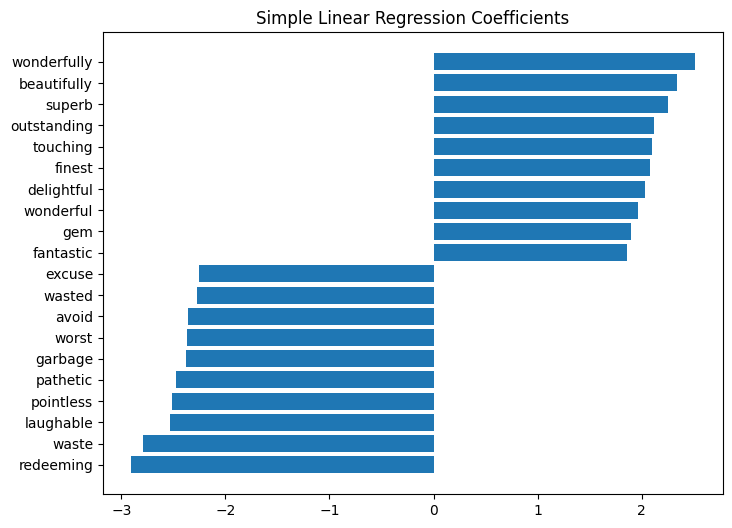

In [ ]:
expl1_top_tuples = coefficient_tuples[:10] + coefficient_tuples[-10:]
expl1_top_words = [words_list[i[0]] for i in expl1_top_tuples]
expl1_top_coeffs = [i[1] for i in expl1_top_tuples]

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.title("Simple Linear Regression Coefficients")
plt.barh(expl1_top_words,expl1_top_coeffs)



## Experiment 2: Cross entropy convergence

Text(0, 0.5, 'Cross Entropy')

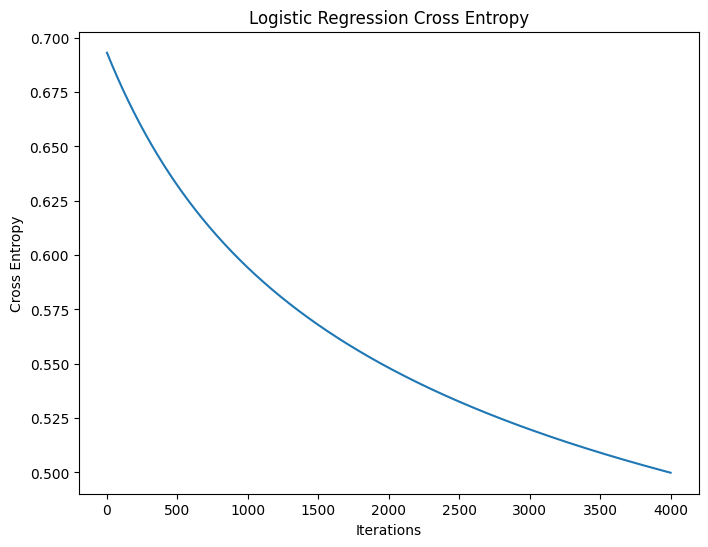

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(range(len(log_ce_list)),log_ce_list)
plt.title("Logistic Regression Cross Entropy")
plt.xlabel("Iterations")
plt.ylabel("Cross Entropy")

This shows that due to the relatively small number of iterations,the model has not yet reached full potential. A low iteration number was chosen for the sake of saving time during fitting, as fitting time is already considerable on Colab.

## Experiment 3: ROC curves for logistic regression and DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier
def get_confusion(predictions, actual):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(predictions)):
        if predictions[i] == actual[i] and actual[i] == 1:
            tp += 1
        elif predictions[i] == actual[i] and actual[i] == 0:
            tn += 1
        elif predictions[i] != actual[i] and actual[i] == 1:
            fn += 1
        else:
            fp += 1
    return [(fp / (fp + tn)),(tp / (tp + fn))]
# print(get_confusion(predicted_arr,y_test_bin))
def get_roc_points(actual, steps):
    threshold = 0
    step = 1 / steps
    points = []
    while threshold <= 1:
        predictions = np.array([logTest.predict(row) for row in matrix_t1])
        predictions = [1 if i >= threshold else 0 for i in predictions]
        points.append(get_confusion(predictions,actual))
        threshold += step
    return points
dtc = DecisionTreeClassifier()
dtc.fit(df_1_chosen,y_bin)
dt_predicted_arr = [dtc.predict(row.reshape(1,-1)) for row in matrix_t1]
lr_points = get_roc_points(y_test_bin,25)
def dt_get_roc_points(actual, steps):
    threshold = 0
    step = 1 / steps
    points = []
    while threshold <= 1.01:
        predictions = dtc.predict_proba(matrix_t1)[:,1]
        predictions = [1 if i >= threshold else 0 for i in predictions]
        points.append(get_confusion(predictions,actual))
        threshold += step
    return points
dt_points = dt_get_roc_points(y_test_bin,25)

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
expl3_lr_fpr, expl3_lr_tpr = zip(*lr_points)
expl3_dt_fpr, expl3_dt_tpr = zip(*dt_points)

print("Logistic regression AUROC:", auc(expl3_lr_fpr, expl3_lr_tpr), "Decision tree AUROC:", auc(expl3_dt_fpr, expl3_dt_tpr))



Logistic regression AUROC: 0.886046256 Decision tree AUROC: 0.7322851328000002


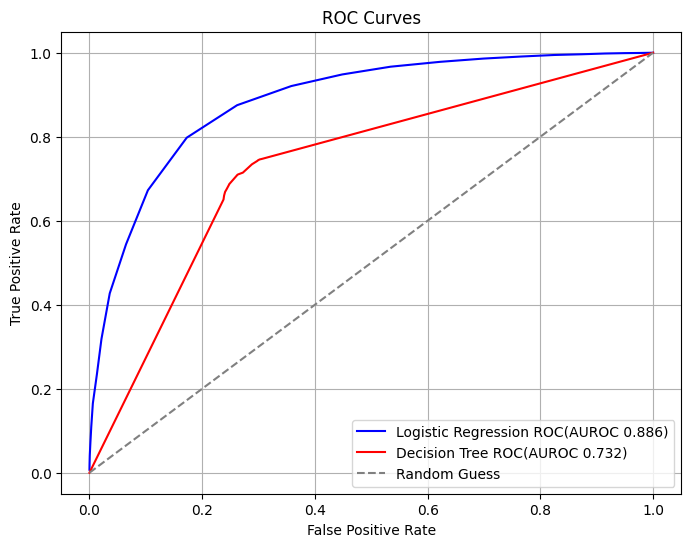

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(expl3_lr_fpr, expl3_lr_tpr, marker='', linestyle='-', color='blue', label='Logistic Regression ROC(AUROC 0.886)')
plt.plot(expl3_dt_fpr, expl3_dt_tpr, marker='', linestyle='-', color='red', label='Decision Tree ROC(AUROC 0.732)')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')

# Adding labels and title
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Show the plot
plt.grid(True)
plt.show()

## Experiment 4: Effects of training data size on AUROC

In [14]:
from sklearn.metrics import roc_auc_score
lr_20 = LogisticRegressor(chosen_indices_list, 0.004, 4000)
dt_20 = DecisionTreeClassifier()

df_1_chosen_20 = pd.concat([df_1_chosen.head(2500), df_1_chosen.tail(2500)], ignore_index=True)
y_bin_20 = np.concatenate([y_bin[:2500],y_bin[-2500:]])
lr_20.fit(df_1_chosen_20, y_bin_20)
dt_20.fit(df_1_chosen_20, y_bin_20)

lr_20_predictions = np.array([lr_20.predict(row) for row in matrix_t1])
dt_20_predictions = dt_20.predict_proba(matrix_t1)[:,1]

lr_auroc_20 = roc_auc_score(y_test_bin,lr_20_predictions)
dt_auroc_20 = roc_auc_score(y_test_bin,dt_20_predictions)

print(lr_auroc_20, dt_auroc_20)





0.8858198208000001 0.7172818528


In [15]:
del lr_20
del dt_20
del df_1_chosen_20
del y_bin_20
del lr_20_predictions
del dt_20_predictions
gc.collect()

lr_20 = LogisticRegressor(chosen_indices_list, 0.004, 4000)
dt_20 = DecisionTreeClassifier()

df_1_chosen_20 = pd.concat([df_1_chosen.head(5000), df_1_chosen.tail(5000)], ignore_index=True)
y_bin_20 = np.concatenate([y_bin[:5000],y_bin[-5000:]])
lr_20.fit(df_1_chosen_20, y_bin_20)
dt_20.fit(df_1_chosen_20, y_bin_20)

lr_20_predictions = np.array([lr_20.predict(row) for row in matrix_t1])
dt_20_predictions = dt_20.predict_proba(matrix_t1)[:,1]

lr_auroc_20 = roc_auc_score(y_test_bin,lr_20_predictions)
dt_auroc_20 = roc_auc_score(y_test_bin,dt_20_predictions)

print(lr_auroc_20, dt_auroc_20)

0.8848284479999999 0.7309003488000001


In [16]:
del lr_20
del dt_20
del df_1_chosen_20
del y_bin_20
del lr_20_predictions
del dt_20_predictions
gc.collect()

lr_20 = LogisticRegressor(chosen_indices_list, 0.004, 4000)
dt_20 = DecisionTreeClassifier()

df_1_chosen_20 = pd.concat([df_1_chosen.head(7500), df_1_chosen.tail(7500)], ignore_index=True)
y_bin_20 = np.concatenate([y_bin[:7500],y_bin[-7500:]])
lr_20.fit(df_1_chosen_20, y_bin_20)
dt_20.fit(df_1_chosen_20, y_bin_20)

lr_20_predictions = np.array([lr_20.predict(row) for row in matrix_t1])
dt_20_predictions = dt_20.predict_proba(matrix_t1)[:,1]

lr_auroc_20 = roc_auc_score(y_test_bin,lr_20_predictions)
dt_auroc_20 = roc_auc_score(y_test_bin,dt_20_predictions)

print(lr_auroc_20, dt_auroc_20)

0.8859685312000001 0.7335569376000001


In [17]:
del lr_20
del dt_20
del df_1_chosen_20
del y_bin_20
del lr_20_predictions
del dt_20_predictions
gc.collect()

lr_20 = LogisticRegressor(chosen_indices_list, 0.004, 4000)
dt_20 = DecisionTreeClassifier()

df_1_chosen_20 = pd.concat([df_1_chosen.head(10000), df_1_chosen.tail(10000)], ignore_index=True)
y_bin_20 = np.concatenate([y_bin[:10000],y_bin[-10000:]])
lr_20.fit(df_1_chosen_20, y_bin_20)
dt_20.fit(df_1_chosen_20, y_bin_20)

lr_20_predictions = np.array([lr_20.predict(row) for row in matrix_t1])
dt_20_predictions = dt_20.predict_proba(matrix_t1)[:,1]

lr_auroc_20 = roc_auc_score(y_test_bin,lr_20_predictions)
dt_auroc_20 = roc_auc_score(y_test_bin,dt_20_predictions)

print(lr_auroc_20, dt_auroc_20)

0.8869419648 0.726522832


# Experiment 5: A bar plot that shows the classification accuracies of logistic regression and DT on the test data (y-axis) as a function of the 20%, 40%, 60%, 80%, and 100% training data (xaxis)

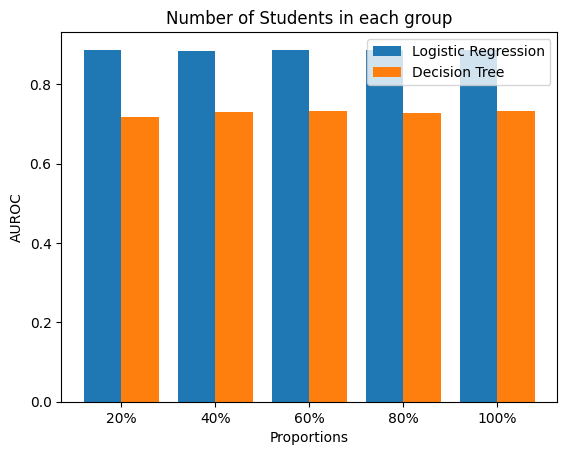

In [18]:
bar_labels = ['20%','40%','60%','80%','100%']
Ylr = [0.8858198208000001,0.8848284479999999,0.8859685312000001,0.8869419648,0.886046256]
Ydt = [0.7172818528,0.7309003488000001,0.7335569376000001,0.726522832,0.7322851328000002]

X_axis = np.arange(5)

plt.bar(X_axis - 0.2, Ylr, 0.4, label = 'Logistic Regression')
plt.bar(X_axis + 0.2, Ydt, 0.4, label = 'Decision Tree')

plt.xticks(X_axis, bar_labels)
plt.xlabel("Proportions")
plt.ylabel("AUROC")
plt.title("Number of Students in each group")
plt.legend()
plt.show()

Both AUROCs for logistic regression and decision tree more or less stagnate, which could be because 5000 samples is a significant enough training data size.

## Experiment 6: Top 20 words according to logistic regression

In [ ]:
logTest.get_best_words_by_coeffs()

[('bad', -0.5522213445807665),
 ('worst', -0.40506918756174237),
 ('nothing', -0.2648094061915944),
 ('waste', -0.2645869430842744),
 ('awful', -0.25509463091970674),
 ('boring', -0.22825778065317823),
 ('minutes', -0.21496580053969397),
 ('terrible', -0.21282754390379222),
 ('poor', -0.20985398628878613),
 ('stupid', -0.2040351673856402),
 ('performance', 0.15115702733700292),
 ('favorite', 0.15895287584977089),
 ('loved', 0.1625045284374061),
 ('amazing', 0.16854519215041497),
 ('perfect', 0.18916609989655006),
 ('beautiful', 0.19491821396703393),
 ('wonderful', 0.22336990369848614),
 ('excellent', 0.2743917925514627),
 ('best', 0.332560079262146),
 ('great', 0.46389736579827967)]

<BarContainer object of 20 artists>

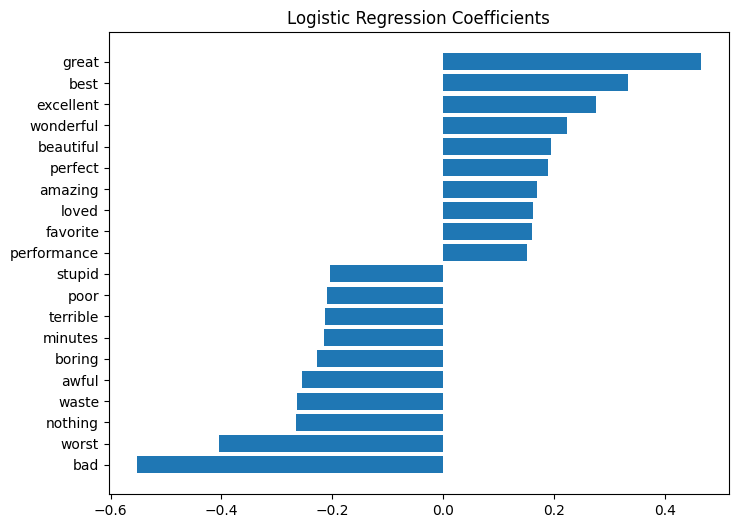

In [ ]:
expl6_words, expl6_coeffs = zip(*logTest.get_best_words_by_coeffs())
plt.figure(figsize=(8, 6))
plt.title("Logistic Regression Coefficients")
plt.barh(expl6_words,expl6_coeffs)

# Loading the dataset 20newsgroups

In [ ]:
categories = ['comp.graphics', 'rec.sport.baseball', 'sci.med', 'talk.politics.guns', 'misc.forsale']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)

# Preprocessing

In [ ]:
# Filter the vocabularies and Create the feature vectors using sklearn library this time
# TfidfVectorizer combines TfidfTransformer and CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=500)  # Limit to 500 features, you can change it to any number you want
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)

# Select the top features using mutual information

In [ ]:
def top_features_per_class(X_train, y_train, num_features_per_class=10):
    num_classes = np.unique(y_train).shape[0]
    top_features_per_class = set()

    for _class in range(num_classes):
        # Create a binary label for the current class
        y_binary = (y_train == _class).astype(int)

        # Calculate the mutual information score for each feature
        mi_score = mutual_info_classif(X_train, y_binary, discrete_features='auto')

        # Get the indices of the top features
        top_features = np.argsort(mi_score)[-num_features_per_class:]
        top_features_per_class.update(top_features)

    # Convert to a sorted list to maintain consistency
    selected_indices = sorted(list(top_features_per_class))

    return selected_indices

In [ ]:
selected_indices = top_features_per_class(X_train, newsgroups_train.target, 80)
feature_names = np.array(vectorizer.get_feature_names_out())
top_words = feature_names[list(selected_indices)]

In [ ]:
#re-create the dataset with only the selected features
vectorizer = TfidfVectorizer(stop_words='english',vocabulary=top_words)
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)

X_train_tfidfV_df = pd.DataFrame(X_train.todense())
X_train_tfidfV_df.columns = sorted(vectorizer.vocabulary_)
X_train_tfidfV_df.shape
X_train_tfidfV_df.head()


X_test_tfidfV_df = pd.DataFrame(X_test.todense())
X_test_tfidfV_df.columns = sorted(vectorizer.vocabulary_)

# Define MultiClass Regression

In [ ]:
class MultiClass_Regression:
  def __init__(self, nFeatures, nClasses, learningRate = 0.005, nIter = 1000):
    self.W = np.random.rand(nFeatures, nClasses)
    self.learningRate = learningRate
    self.nIter = nIter

  def predict(self, X):
    y_pred = np.exp(np.matmul(X, self.W))
    return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

  def grad(self, X, y):
    return np.matmul(X.transpose(), self.predict(X) - y)

  def ce(self, X, y):
    return -np.sum(y * np.log(self.predict(X)))

  def fit(self, X, y):
    losses_train = np.zeros(self.nIter)
    for i in range(self.nIter):
      grad = self.grad(X, y)
      loss_train = self.ce(X, y)
      losses_train[i] = loss_train
      self.W = self.W - self.learningRate * grad
    return losses_train

  def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        return diff.sum()

In [ ]:
#one-hot encode the class vector
y_one_hot_train = np.eye(5)[newsgroups_train.target]
y_one_hot_test = np.eye(5)[newsgroups_test.target]

# Experiment 2: Convergence plot on how the logistic and multiclass regression converge given a reasonably chosen learning rate.

In [ ]:
mlr = MultiClass_Regression(X_train_tfidfV_df.to_numpy().shape[1], y_one_hot_train.shape[1], learningRate = 0.00005, nIter = 10000)
ce_train = mlr.fit(X_train_tfidfV_df.to_numpy(), y_one_hot_train)

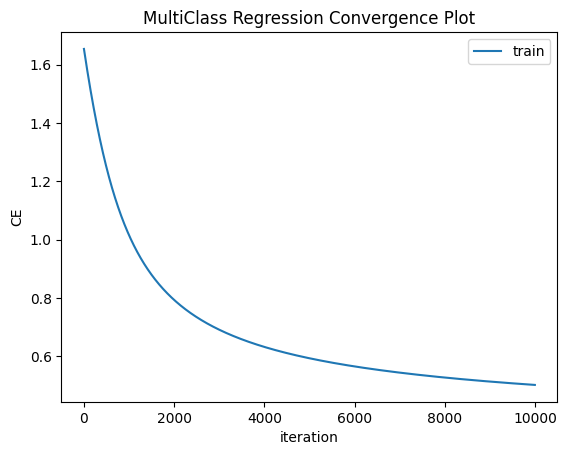

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.title('MultiClass Regression Convergence Plot')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

In [ ]:
#check gradient

print(mlr.check_grad(X_train_tfidfV_df.to_numpy(), y_one_hot_train))

4.927296481424187e-11


In [ ]:
predicted = mlr.predict(X_test_tfidfV_df.to_numpy())

def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

test_accuracy = evaluate(mlr.predict(X_test_tfidfV_df.to_numpy()), y_one_hot_test)
print("Test Classification Accuracy is:", test_accuracy)

Test Classification Accuracy is: 0.7494834710743802


# Experiment 7: Heatmap

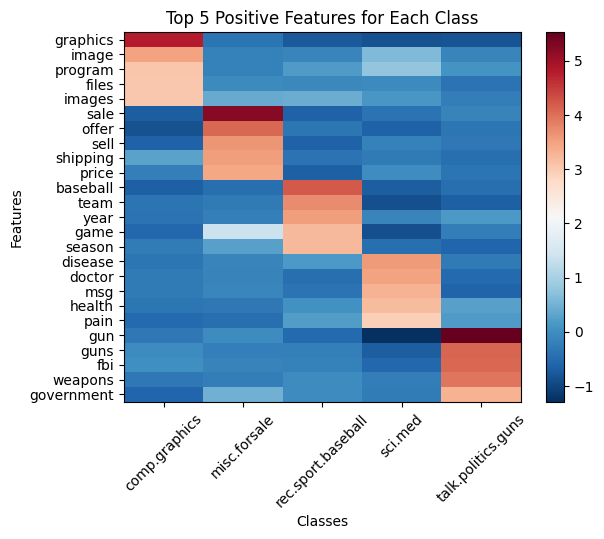

In [ ]:
W_hat = mlr.W

top_positive_indices = np.argsort(-W_hat, axis=0)[:5, :]
flatten = []

for i in range(5):
  for j in range(5):
    flatten.append(top_positive_indices[j][i])

top_positive_indices = flatten

feature_names = []

for index in top_positive_indices:
  actual_feature = top_words[index]
  feature_names.append(actual_feature)

heatmap_data = np.zeros((25,5))

for news_class in range(5):
  for i, feature in enumerate(top_positive_indices):
      heatmap_data[i, news_class] = W_hat[feature, news_class]

# Plot the heatmap
plt.imshow(heatmap_data, cmap='RdBu_r', aspect='auto')
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.xticks(ticks=np.arange(len(categories)), labels=newsgroups_test.target_names, rotation=45)
plt.colorbar()
plt.xlabel('Classes')
plt.ylabel('Features')
plt.title('Top 5 Positive Features for Each Class')
plt.savefig("top_positive_features_heatmap.png")
plt.show()

# Experiment 5: A bar plot that shows the classification accuracies of multiclass regression and DT on the test data (y-axis) as a function of the 20%, 40%, 60%, 80%, and 100% training data (xaxis)

In [ ]:
multiclass_regression_test_accuracies = []
DT_test_accuracies = []

for i in range(1,6):
  percentage = i * 0.20
  how_many_rows = int(percentage * X_train_tfidfV_df.to_numpy().shape[0])

  X_train = X_train_tfidfV_df.to_numpy()[:how_many_rows]
  y_train = y_one_hot_train[:how_many_rows]
  X_test = X_test_tfidfV_df.to_numpy()[:how_many_rows]
  y_test = y_one_hot_test[:how_many_rows]

  mlr = MultiClass_Regression(X_train.shape[1], y_train.shape[1], learningRate = 0.00005, nIter = 10000)
  ce_train = mlr.fit(X_train, y_train)
  predicted = mlr.predict(X_test)
  test_accuracy = evaluate(mlr.predict(X_test), y_test)

  clf = DecisionTreeClassifier()
  clf.fit(X_train, y_train)
  dt_accuracy = evaluate(clf.predict(X_test), y_test)

  print("MultiClass Regression Model Test Classification Accuracy for", i*20, "percent of training data used to train the model is:", test_accuracy)
  print("Decision Tree Model Test Classification Accuracy for", i*20, "percent of training data used to train the model is:", dt_accuracy)
  multiclass_regression_test_accuracies.append(test_accuracy)
  DT_test_accuracies.append(dt_accuracy)

MultiClass Regression Model Test Classification Accuracy for 20 percent of training data used to train the model is: 0.7383820998278829
Decision Tree Model Test Classification Accuracy for 20 percent of training data used to train the model is: 0.5524956970740104
MultiClass Regression Model Test Classification Accuracy for 40 percent of training data used to train the model is: 0.7426850258175559
Decision Tree Model Test Classification Accuracy for 40 percent of training data used to train the model is: 0.608433734939759
MultiClass Regression Model Test Classification Accuracy for 60 percent of training data used to train the model is: 0.7538726333907056
Decision Tree Model Test Classification Accuracy for 60 percent of training data used to train the model is: 0.6397016637980494
MultiClass Regression Model Test Classification Accuracy for 80 percent of training data used to train the model is: 0.7536157024793388
Decision Tree Model Test Classification Accuracy for 80 percent of traini

In [ ]:
print(multiclass_regression_test_accuracies)
print(DT_test_accuracies)

[0.7383820998278829, 0.7426850258175559, 0.7538726333907056, 0.7536157024793388, 0.7551652892561983]
[0.5524956970740104, 0.608433734939759, 0.6397016637980494, 0.6456611570247934, 0.6590909090909091]


<Axes: title={'center': 'Classification Accuracies of MultiClass Regression & Decision Tree Models'}, xlabel='Training Data Percentage'>

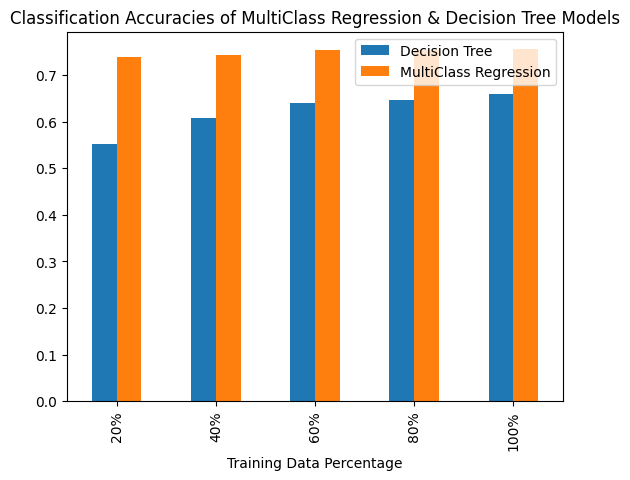

In [ ]:
df = pd.DataFrame({
    'Training Data Percentage': ['20%', '40%', '60%', '80%', '100%'],
    'Decision Tree': DT_test_accuracies,
    'MultiClass Regression': multiclass_regression_test_accuracies
})

# plotting graph
df.plot(x="Training Data Percentage", y=["Decision Tree", "MultiClass Regression"], kind="bar", title="Classification Accuracies of MultiClass Regression & Decision Tree Models")

#Experiment Extra: Trying Different Learning Rates

In [ ]:
test_accuracies_diff_learning_rate = []
for i in (0.9, 0.5, 0.05, 0.005, 0.00005, 0.000005):
  mlr = MultiClass_Regression(X_train.shape[1], y_train.shape[1], learningRate = i, nIter = 10000)
  ce_train = mlr.fit(X_train, y_train)
  predicted = mlr.predict(X_test)
  test_accuracy = evaluate(mlr.predict(X_test), y_test)
  test_accuracies_diff_learning_rate.append(test_accuracy)

In [ ]:
#we see that as we decrease the learning rate, classification rate increases, except when the learning rate is too small to let the model converge

print(test_accuracies_diff_learning_rate)

[0.7024793388429752, 0.7086776859504132, 0.7257231404958677, 0.7360537190082644, 0.7546487603305785, 0.7081611570247934]


In [ ]:
#but we see that we can fix this by increasing the number of iterations and allow the model to converge more

mlr = MultiClass_Regression(X_train.shape[1], y_train.shape[1], learningRate = 0.000005, nIter = 100000)
ce_train = mlr.fit(X_train, y_train)
predicted = mlr.predict(X_test)
test_accuracy = evaluate(mlr.predict(X_test), y_test)
print(test_accuracy)

0.753099173553719
